# Decision Tree Model Training

This notebook trains a Decision Tree classifier for mobile price classification.

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

X_train = train_df.drop('price_range', axis=1)
y_train = train_df['price_range']
X_test = test_df.drop('price_range', axis=1)
y_test = test_df['price_range']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1600, 20)
Test set: (400, 20)


In [4]:
# Preprocessing
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols)],
    remainder='drop'
)

In [5]:
# Hyperparameter tuning
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'clf__max_depth': [5, 10, 15, 20, None],
    'clf__min_samples_split': [2, 5, 10, 20],
    'clf__min_samples_leaf': [1, 2, 4, 8],
    'clf__criterion': ['gini', 'entropy'],
    'clf__splitter': ['best', 'random']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 320 candidates, totalling 1600 fits

Best parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 2, 'clf__splitter': 'best'}
Best CV score: 0.8462


In [6]:
# Evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8675

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       100
           1       0.85      0.80      0.82       100
           2       0.78      0.80      0.79       100
           3       0.89      0.92      0.91       100

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400




Top 10 Features:
          feature  importance
13            ram    0.725307
0   battery_power    0.113708
12       px_width    0.092831
11      px_height    0.046505
10             pc    0.005174
5          four_g    0.004265
14           sc_h    0.003308
8       mobile_wt    0.003088
9         n_cores    0.001553
6      int_memory    0.001241


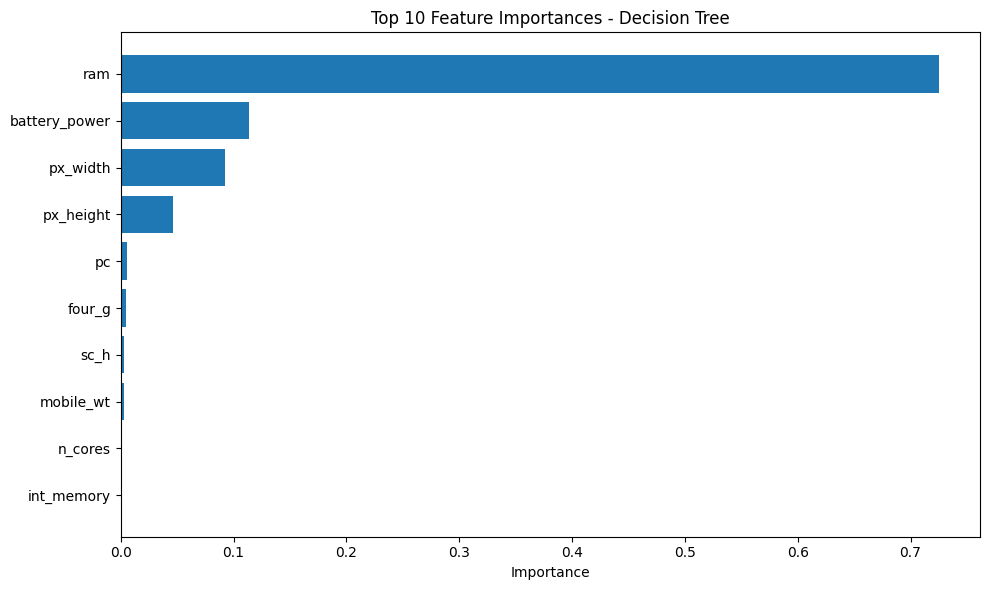

In [7]:
# Feature importance
importance = best_model.named_steps['clf'].feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:10], importance_df['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

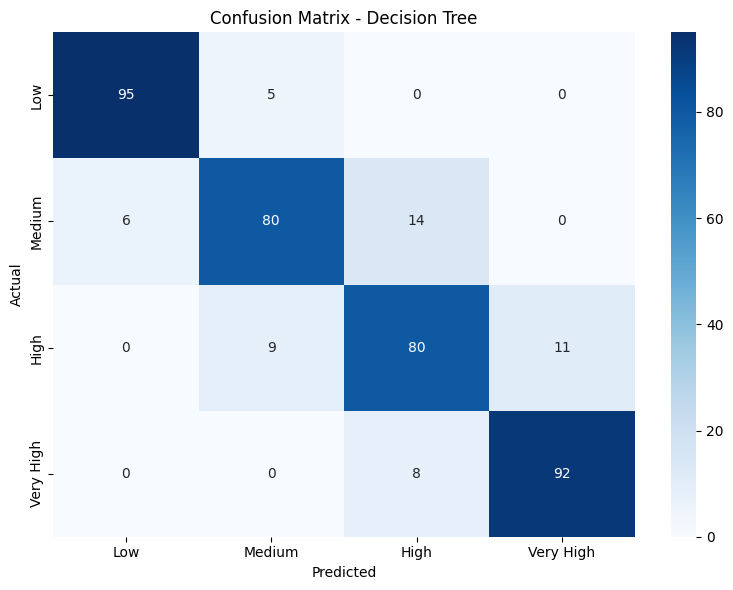

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High', 'Very High'],
            yticklabels=['Low', 'Medium', 'High', 'Very High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.show()

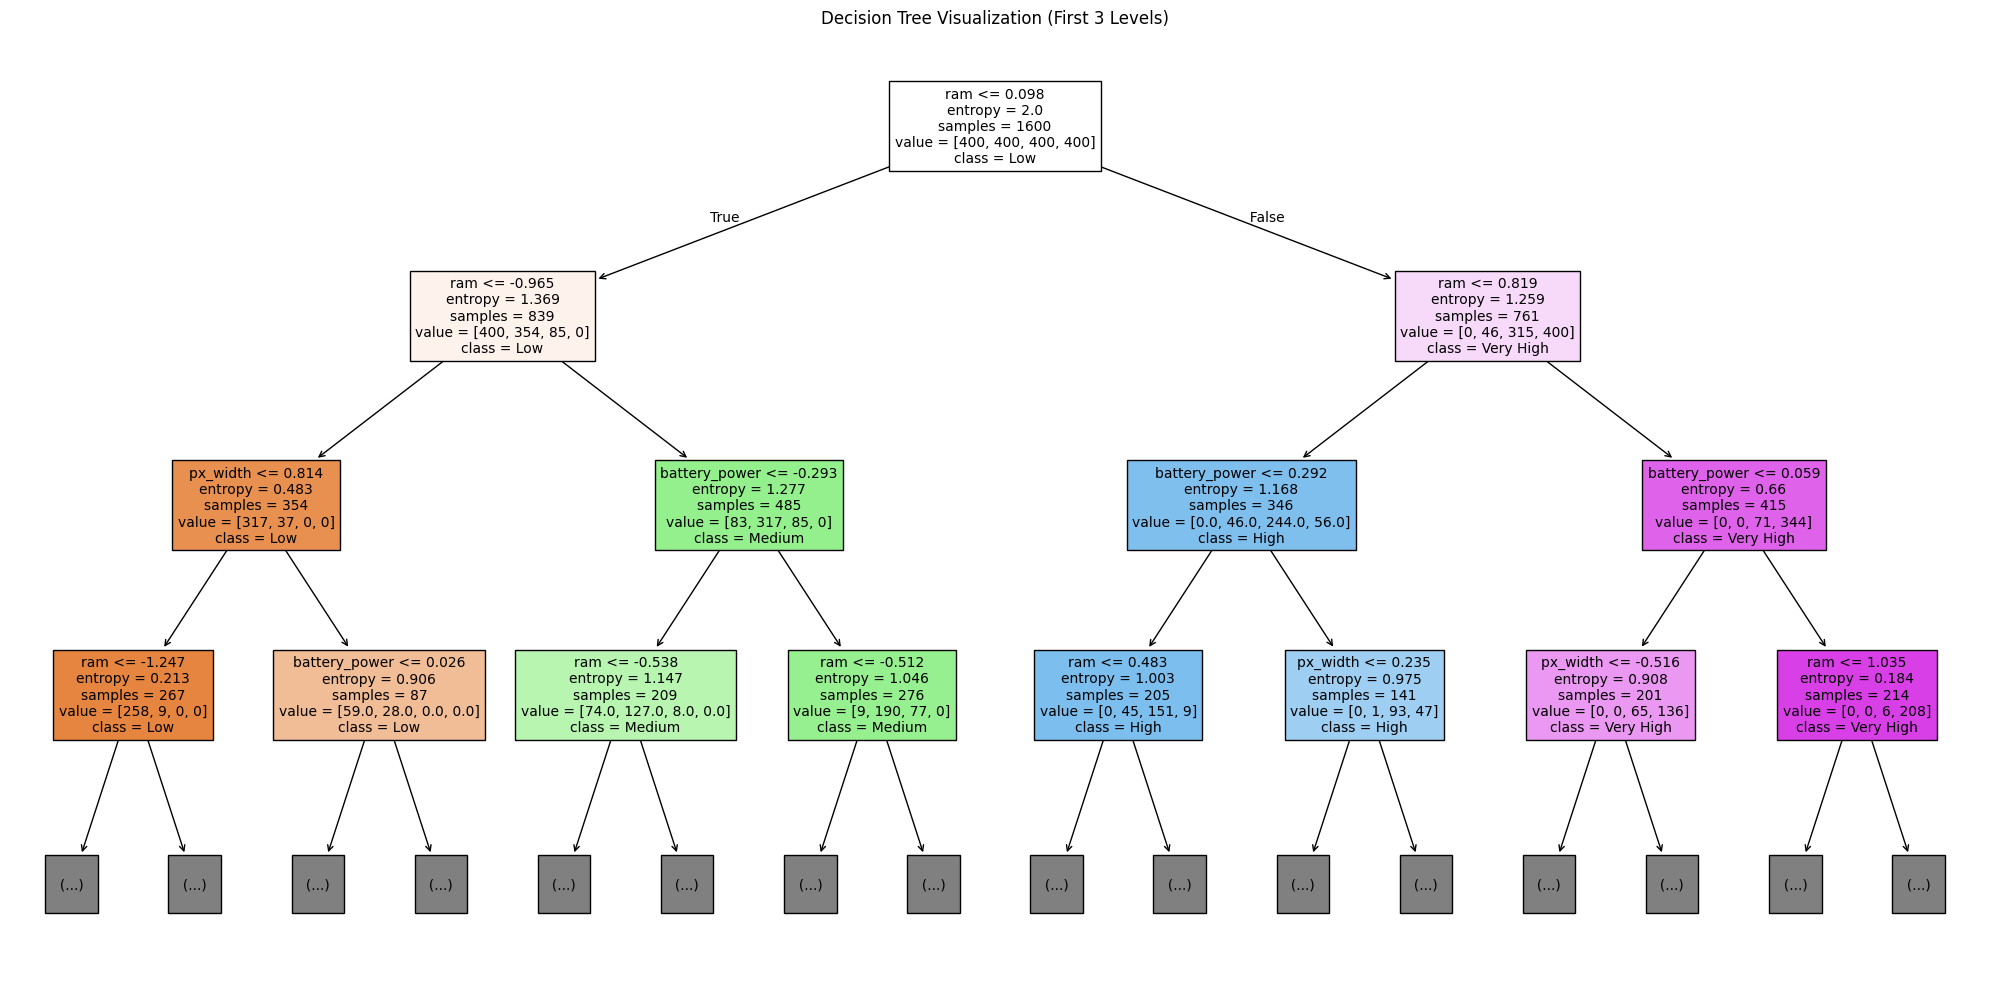

In [9]:
# Visualize tree (first few levels)
plt.figure(figsize=(20, 10))
plot_tree(best_model.named_steps['clf'], 
          max_depth=3,
          feature_names=X_train.columns,
          class_names=['Low', 'Medium', 'High', 'Very High'],
          filled=True,
          fontsize=10)
plt.title('Decision Tree Visualization (First 3 Levels)')
plt.tight_layout()
plt.show()

In [10]:
# Save model
joblib.dump(best_model, 'saved_models/Decision_Tree_model.joblib')
print("Model saved to saved_models/Decision_Tree_model.joblib")

Model saved to saved_models/Decision_Tree_model.joblib
